# Extended jet model
## *Hillas meets Eddington: the case for blazars as UHE neurtino sources*
## Rodrigues, Rieger, Bohdan and Padovani 2025

In [ ]:
import os
import sys
import time
import numpy as np
import astropy.units as u   
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.constants import codata2010 as const
from astropy.constants import kpc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
np.seterr(all="ignore") # Ignore warnings
from scipy.integrate import cumulative_trapezoid
import pickle

m_e_ev = (const.m_e * const.c ** 2).to(u.eV).value
m_p_ev = (const.m_p * const.c ** 2).to(u.eV).value
ev_to_hz = u.eV.to(u.J)/const.h.value

cmtopc = u.cm.to(u.pc)
pctocm = 1./cmtopc

os.environ["GAMMAPY_DATA"] = "data/"
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)
domingue = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=0.)

import am3
am3 = am3.AM3()

am3.update_energy_grid(1e-9,1e9,1e21) # set Emin to 1e-9 !


# Plotting defs
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['font.size'] = 11
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['font.size'] = 11
plot_colors = np.array([np.array([230,159,  0.]),
                    np.array([ 86,180,233.]),
                    np.array([  0,158,115.]),
                    np.array([240,228, 66.]),
                    np.array([  0,114,178.]),
                    np.array([213, 94,  0.]),
                    np.array([201,121,176.])]) /255.
carr = list(plot_colors) * 100


In [124]:
# Fixed parameters
PARS = {'T_torus' : 500 * u.K,
        'f_BLR' : 0.1 / 1.5,
        'f_torus' : 0.3,
        'gamma_min' : 100.,
        'ZONES_PER_DECADE' : 30,
        # AM3 parameters
        'am3_timestep' : 0.1,
        'am3_simtime' : 3,
        }

# Source data
with open('data/sourcedata_TXS_0506+056.pkl', 'rb') as f:
    SOURCEDATA = pickle.load(f)

In [ ]:
##########################################
# AM3 SETUP AND KERNEL INITIALIZATION
##########################################
# Run only once: computational bottleneck!
##########################################

# Set to 0 for maximum efficiency, or to 1 for plotting separaatte SED contributions
am3.set_process_parse_sed(1)

# Hadronic processes on
am3.set_process_hadronic(1)

# Keep track of positrons and electrons separately
am3.set_process_merge_positrons_into_electrons(0)

# Escape (see documantation)
am3.set_process_escape(1)

# Expansion of radiation zone (see documantation)
am3.set_process_expansion(0)
am3.set_process_adiabatic_cooling(1)

# Electron synchrotron and synchrotron self-absorption
am3.set_process_electron_syn(1)
am3.set_process_ssa(1)

# Proton synchrotron - subdominant in this case, but may be relevant for B>~10 G
am3.set_process_proton_syn(1)

# Quantum synchrotron off by default.
# In AGN simulations this effect can typically be neglected, so turn off for efficiency
am3.set_process_quantum_syn(0)

# Inverse Compton by electrons and protons 
am3.set_process_electron_compton(1)
am3.set_process_proton_compton(1)

# Direct Compton turned off by default
am3.set_process_compton_photon_energy_loss(0)

# Synchrotron and inverse Compton by muons and pions - off by default.
# In AGN simulations this effect can typically be neglected, so turn off for efficiency
am3.set_process_muon_syn(0)
am3.set_process_pion_syn(0)
am3.set_process_muon_compton(0)
am3.set_process_pion_compton(0)

# Secondary particle decay
am3.set_process_pion_decay(1)
am3.set_process_muon_decay(1)

# Photon annihilation (gamma gamma -> e- e+)
am3.set_process_annihilation(1)
am3.set_optimize_annihilation_pair_emission(1) # optimization

# Bethe-Heitler pair production (p gamma -> p e+ e-)
am3.set_process_bethe_heitler(1)
am3.set_optimize_bethe_heitler_outgoing_pairs_grid(1)
am3.set_optimize_bethe_heitler_incoming_protons_min(1e12)
am3.set_optimize_bethe_heitler_target_photon_max(1e6)

# Photo-pion production (nucleon gamma -> nucleon pion)
am3.set_process_photopion(1)
am3.set_optimize_photopion_target_photon_grid(1)
am3.set_optimize_photopion_target_photon_max(1e6)

# Initialize the kernels with the above switches
am3.init_kernels()



init. AM3 kernels:
AM3 has the following switches (at step: 0)
estimate maximum energies: 0
parse sed components: 1
escape: 1
expansion: 0
adiabatic: 1
synchrotron:
  e+/-: 1  (em..: 1, cool.: 1)
  protons:1  (em..: 1, cool.: 1)
  pions:0  (em..: 1, cool.: 1)
  muons:0  (em..: 1, cool.: 1)
  syn-self-abs.:1
  e+/- quantum-syn.:0
inv. Compton:
  e+/-: 1  (em.. : 1, cool.: 1 (continuous))
  photon loss due to upscattering: 0
  protons:1  (em.. (step approx.): 1, no cooling)
  pions:0  (em.. (step approx.): 1, cont. cool.: 1)
  muons:0  (em.. (step approx.): 1, cont. cool.: 1)
pair prod. (gamma+gamma->e+e)1  (photon loss.: 1, e+/- source (feedback): 1(opt. 14-bin kernel))
'hadronic' processes (below): 1
 Pion decay: 1 Muon decay:1)
proton Bethe-Heitler: 1  (em..: 1, cool.: 1)
proton photo-pion: 1  (em..: 1, cool.: 1, photon loss: 1)
proton p-p: 1  (em..: 1 , cool.: 1)

AM3 params (comoving):
escape_timescale: 7545.31 s
  with fractions: (protons: 1, neutrons: 1, pions: 1, muons: 1, neutri

KeyboardInterrupt: 

In [118]:
###########################
# ASTROPHYSICAL DEFINITIONS
###########################


def eddington_lum(m_bh):
    '''Eddington limit [erg/s]

    m_bh: black hole mass [m_solar]
    '''
    return 1.26e38 * m_bh


def Schwarzschild(m_bh):
    '''Schwarzschild radius [cm]
    
    m_bh: black hole mass [m_solar]
    '''
    rad = (2 * const.G * m_bh * 1.989e30*u.kg 
           / const.c ** 2)
    return rad.to(u.cm)


def get_blr_radius(L_disk):
    '''Broad-line region radius [cm]
    
    L_disk: disc luminosity [erg/s]
    '''
    return 1e17 * (L_disk / 1e45) ** 0.5  # [cm]

def get_torus_radius(L_disk):
    '''Dust torus radius [cm]
    
    L_disk: disc luminosity [erg/s]
    '''
    return 2.5e18 * (L_disk / 1e45) ** 0.5  # [cm]


def PlanckDistribution(earr, temperature, lum):
    '''Thermal Distribution (unnormalized)

    return: E^2dN/dE [a.u.]
    par earr (array): photon energy [eV]
    par temperature [K]
    par lum: total luminosity [erg/s]
    '''
    lgr = earr / temperature / const.k_B.to(u.eV/u.K)
    exparr = np.exp(lgr) - 1
    ednde = earr ** 4 / exparr
    integ = np.trapz(ednde / earr, earr)
    return ednde * lum / integ


def DiskTemperature(rad, lumdisk, m_bh, eta=0.08):
    '''Radius-dependent disk temperature [K]
    '''
    sb = const.sigma_sb.to(u.erg/u.s/
                           u.K**4/u.cm**2)
    rsch = Schwarzschild(m_bh)
    
    term1 = 3 * rsch * lumdisk / (16 * np.pi * eta 
                                  * sb * rad ** 3)
    term2 = 1 - (3 * rsch / rad) ** 0.5
    return (term1 * term2) ** 0.25
 

def ShakuraFlux(earr, lumdisk, m_bh, thetaobs=3.0, eta=0.08):
    '''Disk spectral flux in the observer's frame [erg/cm2/s]
    
    earr (array): photon energies [eV]
    lumdisk: [erg/s]
    m_bh: black hole mass / m_solar
    thetaobs: angle btw. LOS and disk rotation axis (deg)
    '''
    kB = const.k_B.to(u.eV/u.K)
    c0 = const.c.cgs
    hplanck = const.h.to(u.eV*u.s)
    rsch = Schwarzschild(m_bh)
    rin = 3 * rsch
    rout = 300 * rsch
    radarr = np.linspace(rin, rout, 50)
    
    frac = (4 * np.pi) ** 2 * hplanck * np.cos(thetaobs*np.pi/180) / c0 ** 2
    nuarr = earr / hplanck       # convert x-axis to obs frame
    en2d = earr[:,np.newaxis]    # convert x-axis to obs frame
    rad2d = radarr[np.newaxis,:]
    temp2d = DiskTemperature(rad2d,lumdisk,m_bh,eta) # K
    
    integrand = rad2d / (np.exp(en2d/temp2d/kB) - 1)
    integral = np.trapz(integrand, radarr, axis=1)
    Fnu = (nuarr ** 3 * frac * integral).to(u.erg)
    return nuarr * Fnu

def BroadLine(earr, center, width, lum):
    '''
    Broad line spectrum, normalized to `lum` 

    return: E^2dN/dE [a.u.]
    par earr (array): photon energies (eV)
    par center: line energy [eV]
    par width: line width (eV)
    par lum: line luminosity [erg/s]
    '''
    ednde = np.exp(-0.5 
                   * (earr - center) ** 2 
                   / width ** 2
                  )
#     ednde[ednde < 1e-100] = 0.
    integ = np.trapz(ednde/earr, earr)
    ednde *= lum / integ
    return ednde

def get_BLR_density_scaling(R_zone, R_diss, lorentz):
    '''Scaling of the photon density seen in the jet frame 
    with the dissipation radius, according to Eq. 20 of 
    Ghisellini+Tavecchio 0902.0793
    '''

    def scaling_for_large_R_diss(R_diss, R_zone, lorentz):
        beta = (1 - 1. / lorentz ** 2) ** 0.5
        mu1 = (1 + (R_zone / R_diss) ** 2) ** -.5
        mu2 = (1 - (R_zone / R_diss) ** 2) ** .5
        f_mu = (2 * (1 - beta * mu1) ** 3
                - (1 - beta * mu2) ** 3
                - (1 - beta) ** 3)
        return f_mu / 3. / beta

    f0 = 17. / 12
    
    if R_diss <= R_zone:
        scaling = f0
        
    elif R_diss >= 3 * R_zone:
        scaling = scaling_for_large_R_diss(
            R_diss,
            R_zone,
            lorentz)
        
    elif R_zone < R_diss < 3 * R_zone:
        # Power-law interpolation
        f_3R = scaling_for_large_R_diss(
            3 * R_zone, 
            R_zone,
            lorentz
        )
        scaling = 10 **(
            (np.log10(f_3R) - np.log10(f0))
            / (np.log10(3 * R_zone) - np.log10(R_zone))
            * (np.log10(R_diss) - np.log10(R_zone))
        )
        
    return scaling
     
def tangential_angle(R_BLR, R_diss):
    '''Characteristic angle of the radiaiton, which is the tangential angle,
    This is the orientation where external fields dominate.

    R_BLR : broad-line region radius [cm]
    R_diss : distance to the black hole [cm]
    '''
    csi = np.arcsin(R_BLR/R_diss)
    return csi

def calc_doppler(lorentz, R_BLR, R_diss):
    '''Relative Doppler factor between jet and the broad-line region

    lorentz : local jet bulk Lorentz factor
    R_diss : distance to the black hole [cm]
    R_BLR : broad-line region radius [cm].
    '''
    if R_diss <= R_BLR:
        return lorentz
         
    csi = tangential_angle(R_BLR, R_diss)
    beta = (1 - 1. / lorentz ** 2) ** 0.5
    doppler = lorentz * (1 - beta * np.cos(csi))
    return doppler

def doppler_factor(theta_obs, Gamma):

    beta = np.sqrt(1 - 1 / Gamma ** 2)
    delta = 1 / (Gamma * (1 - beta * np.cos(theta_obs)))
    return delta

def convert_lum_to_density_in_jet(R_diss, lorentz, R_BLR):
        ''' Convert external field luminosity in the rest frame of the 
        black hole in [erg/s] into energy density in the comoving frame 
        of the jet blob in [GeV / cm^3]. R_BLR can represent the BLR radius
        or the dust torus radius. 

        return: conversion factor [GeV erg^-1 s cm^-3]
        '''      
        if R_diss < 1e-100: R_diss += 1e-100 
        if lorentz < 1e-100: lorentz += 1e-100 
        if R_BLR < 1e-100: R_BLR += 1e-100
            
        doppler_fact = calc_doppler(lorentz, R_BLR, R_diss)
        
        f1 = (lorentz ** 2 
                / (4.
                    * np.pi 
                    * R_BLR ** 2 
                    * const.c.cgs.value)
                * u.erg.to('GeV'))
                
        f2 = get_BLR_density_scaling(R_BLR, R_diss, lorentz)
        factor =  f1 * f2 
        
        return factor


def convert_torus_lum_to_density_in_jet(R_diss, lorentz, R_torus):
        ''' Convert external field luminosity in the rest frame of the 
        black hole in [erg/s] into energy density in the comoving frame 
        of the jet blob in [GeV / cm^3]. R_BLR can represent the BLR radius
        or the dust torus radius. 

        return: conversion factor [GeV erg^-1 s cm^-3]
        '''      
        if R_diss < 1e-100: R_diss += 1e-100 
        if lorentz < 1e-100: lorentz += 1e-100 
            
        csi = np.arctan(R_torus / R_diss) # i think
        beta = (1 - 1. / lorentz ** 2) ** 0.5
        doppler_fact = lorentz * (1 - beta * np.cos(csi))

        factor = (doppler_fact ** 2 
                / (4.
                    * np.pi 
                    * (R_torus ** 2 + R_diss ** 2) 
                    * const.c.cgs.value)
                * u.erg.to('GeV'))
        
        
        return factor

###################
## TEMPLATES
###################

def get_blue_bump(redshift, disklum, threshold=0):
    
    blue_bump_file ='data/BlueBumpTemplNormalised_4py.txt'
    dataTempl_BB = pd.read_csv(blue_bump_file, delimiter="\s+", names=["Frequency", "Flux"],  skiprows=1, header=None)
    dataTempl_BB["FreqObserverframe"] = dataTempl_BB["Frequency"] / (1. + redshift)

    scaling_factor = disklum / np.max(dataTempl_BB["Flux"])
    dataTempl_BB["Flux5000"] = dataTempl_BB["Flux"] * scaling_factor
    if redshift <= 0.:
        print("[get_blue_bump]Error: z=0!")
        return
    distance = cosmo.luminosity_distance(redshift)*kpc*1e5

    # 1e15 = 2500 A                                                                                                                                                       
    # 1.938 is the flux value at nu = 1.2e15 in the BlueBumpTemplNormalised_4py.txt file                                                                                   
    # 0.154 is the flux value at nu = 2.41E17 in the BlueBumpTemplNormalised_4py.txt file                                                                                  
    nulnuat1p2e15 = 4.*np.pi*distance.value**2*scaling_factor*1.938
    scalingXflux = 10.**((-0.137*np.log10(nulnuat1p2e15)+4.704+1.0)*2.605)/0.154
    ddUVOTTB = dataTempl_BB [dataTempl_BB["Frequency"] < 1e16]
    ddXTB = dataTempl_BB [dataTempl_BB["Frequency"] > 1e16]
    x, y = ddUVOTTB["FreqObserverframe"], ddUVOTTB["Flux5000"]
    y[x<threshold] *= 0
    
    return x, y, y * 0


def get_giant_elliptical(redshift, plot=0, **kwargs):
    label = kwargs['label'] if 'label' in kwargs else None
    
    distance =  cosmo.luminosity_distance(redshift)*kpc*1e5
    const = 4.*np.pi*distance.value**2
    ge_template_file ='data/GiantEllipticalTemplate_4py.txt'
    dataTempl_GE = pd.read_csv(ge_template_file, delimiter="\s+", names=["Frequency", "Luminosity"],  skiprows=1, header=None)
    dataTempl_GE["FreqObserverframe"] = dataTempl_GE["Frequency"] / (1. + redshift)
    dataTempl_GE["Flux"] = dataTempl_GE["Luminosity"] / const * 1.0
    x, y = dataTempl_GE["FreqObserverframe"],dataTempl_GE["Flux"]
    if plot:
        # plt.gca().errorbar(x, y, xerr=None, yerr=None, fmt='o', color = '#ff33cc', markersize='1', ls ='-')
        plt.loglog(x, y, color = '#ff33cc', ls ='-', label=label)
    return x, y


def get_etotal_from_number(n, alpha, emin, emax):
    
    egrid = np.logspace(np.log10(emin), # eV
                        np.log10(emax),
                        100)
    epowerlaw = (egrid ** (2 - alpha) 
                    * (egrid >= emin)
                    * np.exp(- egrid / emax)
                )
    ntrapz = np.trapz(epowerlaw / egrid ** 2, egrid)    
    normalized = epowerlaw * n / ntrapz 
    etotal = np.trapz(epowerlaw / egrid, egrid) * u.eV.to(u.erg)
    
    return etotal # erg


    
def run_single_zone(r, local_pars, disk_lum, verbose=0):


    am3.set_mag_field(local_pars['magfield'])
    am3.set_escape_timescale(local_pars['R_jet'] / const.c.cgs.value) # 4.62e16 cm == Size of the region  
    am3.set_expansion_timescale(local_pars['R_jet']  / const.c.cgs.value) # CHECK!! * PARS['lorentz']...
    am3.set_solver_time_step(PARS['am3_timestep'] * am3.get_escape_timescale())
    # am3.set_escape_fraction_pairs(1.0)
    am3.set_t_pair_escape(calc_t_escape_stoch(am3.get_egrid_lep(), local_pars['magfield'], local_pars['R_jet'], local_pars['R_jet'], jet_pars['diffusion_exponent']))#am3.get_egrid_lep()*0 + const.c.cgs.value / PARS['R_jet'] / 10.)#
    am3.set_t_proton_escape(calc_t_escape_stoch(am3.get_egrid_had(), local_pars['magfield'], local_pars['R_jet'], local_pars['R_jet'], jet_pars['diffusion_exponent']))#am3.get_egrid_lep()*0 + const.c.cgs.value / PARS['R_jet'] / 10.)#
    am3.set_t_pion_escape(calc_t_escape_stoch(am3.get_egrid_had(), local_pars['magfield'], local_pars['R_jet'], local_pars['R_jet'], jet_pars['diffusion_exponent']))#am3.get_egrid_lep()*0 + const.c.cgs.value / PARS['R_jet'] / 10.)#
    am3.set_t_muon_escape(calc_t_escape_stoch(am3.get_egrid_had(), local_pars['magfield'], local_pars['R_jet'], local_pars['R_jet'], jet_pars['diffusion_exponent']))#am3.get_egrid_lep()*0 + const.c.cgs.value / PARS['R_jet'] / 10.)#
        
    
    # Construct accelerated electron spectrum
    elec_emin =  local_pars['egammamin'] * (const.m_e * const.c ** 2).to(u.eV).value # eV
    elec_emax =  local_pars['egammamax'] * (const.m_e * const.c ** 2).to(u.eV).value # eV
    eindex =     local_pars['acceleration_spectrum']
    elum =       local_pars['elum'] # erg/s

    R_diss = r
    
    lorentz = local_pars['lor']
    
    egrid = am3.get_egrid_lep()
    epowerlaw = (egrid ** (2 - eindex) 
                    * (egrid >= elec_emin)
                    * np.exp(-egrid / elec_emax)
                )
    
    # Integrate spectrum in erg/s
    etrapz = np.trapz(epowerlaw / egrid, egrid)
    
    # Normalize it to the desired electron lumiosity
    enormalized = epowerlaw * elum / etrapz # erg/s
    
    # Convert it to an energy density injection rate
    volume = 4/3 * np.pi * (am3.get_escape_timescale() * const.c.cgs.value) ** 3
    enormalized /= volume # erg/cm3/s
    
    # And finally to a particle density injection rate
    enormalized /= egrid * u.eV.to(u.erg) # cm-3.s-1
    
    #############################################
    ### Define accelerated proton spectrum
    #############################################
    
    proton_emin =  local_pars['pgammamin'] * (const.m_p * const.c ** 2).to(u.eV).value # eV 
    proton_emax =  local_pars['pgammamax'] * (const.m_p * const.c ** 2).to(u.eV).value # eV
    pindex =     local_pars['acceleration_spectrum']
    plum =       local_pars['plum'] # erg/s
    
    pgrid = am3.get_egrid_had()
    ppowerlaw = (pgrid ** (2 - pindex)
                    * (pgrid >= proton_emin)
                    * np.exp(- pgrid / proton_emax)
                )

    # Integrate spectrum in erg/s
    ptrapz = np.trapz(ppowerlaw / pgrid, pgrid)
          
    # Normalize it to the desired proton lumiosity
    pnormalized = ppowerlaw * plum / ptrapz # erg/s
               
    # Convert it to an energy density injection rate
    volume = 4/3 * np.pi * (am3.get_escape_timescale() * const.c.cgs.value) ** 3
    pnormalized /= volume # erg/cm3/s
        
    # And finally to a particle density injection rate
    pnormalized /= pgrid * u.eV.to(u.erg) # cm-3.s-1
    
    
    #############################################
    ### Define external photon spectrum
    #############################################
    
    # Define BLR and torus parameters


    blr_doppler = calc_doppler(lorentz, get_blr_radius(disk_lum), R_diss)
    torus_doppler = calc_doppler(lorentz,R_TORUS,R_diss)
    
    # AM3 photon grid
    egrid_jetframe = am3.get_egrid_photons() * u.eV 
    
    # Set up array for adding up external fields
    external_photons = np.zeros(egrid_jetframe.size) * u.GeV / u.cm**3
    
    # Scattered thermal disk emission
    templ_diskx, templ_disky = np.loadtxt('data/disk_continuum_template.dat', unpack=1, delimiter=',')
    disky = 10 ** np.interp(np.log10(egrid_jetframe.value / blr_doppler),
                            np.log10(templ_diskx),
                            np.log10(templ_disky)) * (disk_lum / 1e45) * u.erg / u.s
    # Broad line emission
    hybl = BroadLine(egrid_jetframe / blr_doppler, 
                        10.2*u.eV, 10.2*u.eV/20, 
                        disk_lum * u.erg / u.s * PARS['f_BLR'] * 2./3) # H Ly alpha [erg/s]
    hebl = BroadLine(egrid_jetframe / blr_doppler, 
                        40.8*u.eV, 40.8*u.eV/20, 
                        disk_lum * u.erg / u.s * PARS['f_BLR'] * 1./3) # He Ly alpha [erg/s]
    # Convert BLR components to jet frame

    blr_to_jet = convert_lum_to_density_in_jet(R_diss,lorentz,get_blr_radius(disk_lum)) # erg/s -> GeV/cm3 
    blr_to_jet *= u.GeV / u.cm ** 3 / (u.erg / u.s) # give it units

    external_photons += (disky * 0.01 +
                         hybl+  
                         hebl
                         ) * blr_to_jet #* 1e-10 
    
    # Dust torus
    torusy = PlanckDistribution(egrid_jetframe / torus_doppler,
                                PARS['T_torus'],
                                disk_lum * u.erg / u.s * PARS['f_torus']) # [erg/s]  
    # Convert torus emission to jet frame
    tor_to_jet = convert_torus_lum_to_density_in_jet(R_diss,lorentz,R_TORUS) # erg/s -> GeV/cm3 
    tor_to_jet *= u.GeV / u.cm**3 / (u.erg/u.s)  # give it units

    # Add torus to BLR components 
    external_photons += torusy * tor_to_jet 
    
    # Convert summed up components from energy density to photon density in jet frame
    external_photonspectrum = (external_photons / egrid_jetframe).to(u.cm ** -3).value # cm-3
    external_photonspectrum /= am3.get_escape_timescale() # cm-3.s-1

    #######################
    ### INJECT PARTICLES
    #######################
    
    # Reset all particle arrays to zero
    am3.clear_particle_densities()
    am3.evolve_step()
    
    if verbose: print("Injecting electrons and protons...")    
    am3.set_injection_rate_electrons(enormalized)
    am3.set_injection_rate_protons(pnormalized)

    if verbose: print("Injecting external photons...")
    am3.set_current_densities_photons(external_photonspectrum * am3.get_escape_timescale())
    am3.set_injection_rate_photons(external_photonspectrum)

    #######################
    ### RUN SIMULATION
    #######################
    
    if verbose: print("Evolving solver to the steady state...")

    time = 0.
    while time < PARS['am3_simtime'] * am3.get_escape_timescale():

        am3.evolve_step()                  # Evolve solver
        time += am3.get_solver_time_step() # Count time

    return


def calc_t_syn_loss(E, magfield):
    '''Synchrotorn loss timescale [s]

    E : energy [eV]
    magfield : magnetic field strength [Gauss]
    '''
    return 1. / E / magfield ** 2 * 4e14

def larmor(E, magfield):
    '''Larmor radius [cm]

    E : energy [eV]
    magfield : magnetic field strength [Gauss]
    '''
    return (E * u.eV.to(u.erg) /(4.8e-10 * magfield))

def maglum(magfield, R_jet):
    '''Poynting luminosity [erg/s]

    magfield : magnetic field strength [Gauss]
    R_jet : jet cross-section radius [cm]
    '''
    return 1./4 * magfield ** 2 * R_jet ** 2 * const.c.cgs.value


def magnetization(magfield, part_per_sec, L, R_jet):
    '''part_per_sec == total particles / second
    '''
    proton_mass = (const.m_p * const.c**2).cgs.value
    kinetic_density = part_per_sec * proton_mass / (4 * np.pi * R_jet ** 2 * 3e10)

    cr_density = L / (4 * np.pi * R_jet ** 2 * 3e10)
    
    total_energy_density = kinetic_density + cr_density 
    return magfield ** 2 / (4 * np.pi * total_energy_density)

def schwarzschild(m_bh):
    return (2 * const.G * m_bh * 2e30 * u.kg / const.c**2).cgs.value

def calc_sigma(magfield, number_density):
    return magfield ** 2 / (4 * np.pi * number_density * const.m_p.cgs.value * const.c.cgs.value ** 2)

def magnetic_field(magnetization, part_per_sec, L, R_jet):
    '''Ntotal == total particles / second 
    '''
    proton_mass = (const.m_p * const.c**2).cgs.value
    kinetic_density = part_per_sec * proton_mass / (4 * np.pi * R_jet ** 2 * 3e10)

    cr_density = L / (4 * np.pi * R_jet ** 2 * 3e10)
    
    total_energy_density = kinetic_density + cr_density
    return (magnetization  * 4 * np.pi * total_energy_density) ** 0.5

def alfven(magfield, number_density):
    '''Alfven speed [cm/s]. Parameters in cgs
    '''
    # return magfield / (4 * np.pi * number_density * const.m_p.cgs.value) ** 0.5
    sigma = calc_sigma(magfield, number_density)
    return const.c.cgs.value * (sigma / (1 + sigma)) ** 0.5

def tau_stoch(E,magfield,coherence_scale,eta=10.,alpha=0.3): # eta == strength of turbulence (B^2/dB^2)
    rg = larmor(E,magfield)
    return eta * coherence_scale * (rg / coherence_scale) ** (alpha) / const.c.cgs.value

def calc_t_escape_stoch(E, magfield, R_jet, coherence_scale, alpha=0.3):
    t_esc = R_jet * np.maximum(1.0, R_jet / (const.c.cgs.value * tau_stoch(E, magfield, coherence_scale, eta=1.,alpha=alpha))) / const.c.cgs.value
    return t_esc


def calc_accel(e_eV, eta, magfield, stoch=False, coherence_scale=0, number_density=0, alpha=0.3):
    if not stoch:
        return eta * (e_eV / 4.8e-10 / (magfield) / const.c.cgs.value**2)
    tau = tau_stoch(e_eV,magfield,coherence_scale,eta,alpha)
    alf = alfven(magfield, number_density)
    return 3 / (4-alpha) * (const.c.cgs.value / alf) ** 2 * tau

def get_rblob(rdiss, lorentz):
    return rdiss * np.sin(1./lorentz)

def get_imax(part, eta, magfield, R_jet, cool=True, esc=True, include_compton=True, secondorder=0, number_density=0, alpha=0.3):

    if part == 'e':
        cooling = 1e100
        if cool:
           if not include_compton:
               cooling = calc_t_syn_loss(am3.get_egrid_lep(), magfield)
           else:
               cooling = 1/(1/calc_t_syn_loss(am3.get_egrid_lep(), magfield) + 1/am3.get_t_pair_compton())
        escape = 1e100
        if esc == 'adv':
            escape = R_jet/3e10
        if esc:
            escape = calc_t_escape_stoch(am3.get_egrid_lep(), magfield, R_jet, R_jet)
        acceler = calc_accel(am3.get_egrid_lep(), eta, magfield, secondorder, R_jet, number_density, alpha)

    elif part == 'p':
        cooling = 1/(1/am3.get_t_proton_bethe_heitler() + 1/am3.get_t_proton_photopion() + 1/am3.get_t_proton_syn()) if cool else 1e100
        escape = 1e100
        if esc == 'adv':
            escape = R_jet/3e10
        if esc:
            escape = calc_t_escape_stoch(am3.get_egrid_had(), magfield, R_jet, R_jet)
        acceler = calc_accel(am3.get_egrid_had(), eta, magfield, secondorder, R_jet, number_density, alpha)

        # if R_jet > 0.9 * u.pc.to(u.cm) and R_jet < 1.1 * u.pc.to(u.cm):
        #     f=plt.figure()
        #     plt.loglog(am3.get_egrid_had(), cooling * 3e10 * u.cm.to(u.pc), c='red')
        #     plt.loglog(am3.get_egrid_had(), am3.get_egrid_had()*0+R_jet * u.cm.to(u.pc), c='k')
        #     plt.loglog(am3.get_egrid_had(), acceler * 3e10 * u.cm.to(u.pc), c='green')
        #     plt.show()
    else:
        print("[get_imax]Error: particle type not given")
        return

    if not np.any(acceler > escape):
        imax_esc = am3.get_egrid_had().size - 1 if part == 'p' else am3.get_egrid_lep().size - 1
    else:
        imax_esc = np.where(acceler > escape)[0][0]
        
    if not np.any(acceler > cooling):
        imax_cool = am3.get_egrid_had().size - 1 if part == 'p' else am3.get_egrid_lep().size - 1
    else:
        imax_cool = np.where(acceler > cooling)[0][0]

    res = np.min([imax_esc, imax_cool])

    return res

def get_b_eq(l_e, l_p, r_b):
    
    u_e = l_e  / (4 * np.pi * r_b ** 2 * const.c.cgs.value)
    u_p = l_p  / (4 * np.pi * r_b ** 2 * const.c.cgs.value)
    b_eq = (8 * np.pi * (u_e + u_p)) ** 0.5

    return b_eq



def get_n_total(ind, emin, emax, lum):
    egrid = np.logspace(np.log10(emin), 
                        np.log10(emax)+2,
                        100)
    plaw = (egrid ** - ind
                    * np.exp(- egrid / emax)
                )
    lumtrapz = np.trapz(plaw * egrid, egrid) * u.eV.to(u.erg)
    normalized = plaw * lum / lumtrapz 
    ntotal = np.trapz(normalized, egrid)
    return ntotal


def get_etotal_from_number(n, ind, emin, emax):
    
    egrid = np.logspace(np.log10(emin), 
                        np.log10(emax)+2,
                        100)
    plaw = (egrid ** - ind
                    * np.exp(- egrid / emax)
                )
    ntrapz = np.trapz(plaw, egrid)    
    normalized = plaw * n / ntrapz
    etotal = np.trapz(normalized * egrid, egrid) * u.eV.to(u.erg)
    
    return etotal # erg


gmag1x, gmag1y = np.loadtxt("/Users/xrodrigu/analysis/sin/sin-v/data/giann_magnet1.csv",delimiter=',', unpack=1)
gmag2x, gmag2y = np.loadtxt("/Users/xrodrigu/analysis/sin/sin-v/data/giann_magnet2.csv",delimiter=',', unpack=1)
gmag0x, gmag0y = np.loadtxt("/Users/xrodrigu/analysis/sin/sin-v/data/giann_magnet0.csv",delimiter=',', unpack=1)
gmagx = np.logspace(np.log10(gmag1x[0]),np.log10(gmag1x[-1]),100)
gmagy_1 = 10 ** np.interp(np.log10(gmagx), np.log10(gmag1x), np.log10(gmag1y))
gmagy_2 = 10 ** np.interp(np.log10(gmagx), np.log10(gmag2x), np.log10(gmag2y))
gmagy_0 = 10 ** np.interp(np.log10(gmagx), np.log10(gmag0x), np.log10(gmag0y))


def get_prescribed(var, z):
    if var == 'mag':
        y = 10 ** np.interp(np.log10(z), np.log10(gmag0x), np.log10(gmag0y))
    elif var == 'lor':
        y = 10 ** np.interp(np.log10(z), np.log10(glor0x), np.log10(glor0y))
    else:
        print("[get_prescribed]Error: var neither mag nor lor.")
        return
    return y



def within_prescribed(var, z, y):
    if var == 'mag':
        ymin = 10 ** np.interp(np.log10(z), np.log10(gmag2x), np.log10(gmag2y))
        ymax = 10 ** np.interp(np.log10(z), np.log10(gmag1x), np.log10(gmag1y))
    elif var == 'lor':
        ymin = 10 ** np.interp(np.log10(z), np.log10(glor2x), np.log10(glor2y))
        ymax = 10 ** np.interp(np.log10(z), np.log10(glor1x), np.log10(glor1y))
    else:
        print("[within_prescribed]Error: var neither mag nor lor.")
        return
    return y >= ymin and y <= ymax



<>:244: SyntaxWarning: invalid escape sequence '\s'
<>:273: SyntaxWarning: invalid escape sequence '\s'
<>:244: SyntaxWarning: invalid escape sequence '\s'
<>:273: SyntaxWarning: invalid escape sequence '\s'
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_28814/2920513848.py:244: SyntaxWarning: invalid escape sequence '\s'
  dataTempl_BB = pd.read_csv(blue_bump_file, delimiter="\s+", names=["Frequency", "Flux"],  skiprows=1, header=None)
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_28814/2920513848.py:273: SyntaxWarning: invalid escape sequence '\s'
  dataTempl_GE = pd.read_csv(ge_template_file, delimiter="\s+", names=["Frequency", "Luminosity"],  skiprows=1, header=None)


# Extended jet model implementation

f_theta                       : 2.20e-01
L_jet                         : 3.58e+46
alpha_B                       : 1.06e+00
xi_H                          : 7.00e-01
alpha_n                       : 1.95e+00
eta_min                       : 3.40e+00
alpha_eta                     : 7.00e-01
r_eta_min                     : 4.20e+00
diffusion_exponent            : 3.00e-01
acceleration_spectrum         : 1.80e+00
theta_obs                     : 1.05e-02
f_NT_protons                  : 1.32e-07
f_NT_electrons                : 1.71e-06


/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_28814/845879804.py:63: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ = np.trapz(dens_dist_unnorm(np.logspace(np.log10(r0),np.log10(r1),100)), np.logspace(np.log10(r0),np.log10(r1),100))
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_28814/845879804.py:141: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(out)
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_28814/2920513848.py:615: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ntrapz = np.trapz(plaw, egrid)
/var/folders/25/d230kxr90hj414fnx8hg1f_4000956/T/ipykernel_28814/2920513848.py:6

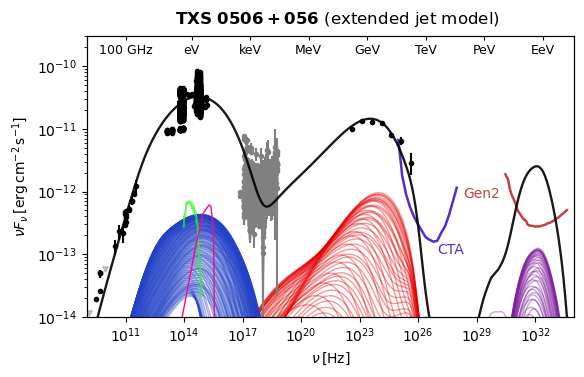

In [141]:
with open('data/bestfit_jet_parameters_TXS_0506+056.pkl', 'rb') as f: # Load best-fit fet parameters (Table 1)
    jet_pars = pickle.load(f)

for k,v in jet_pars.items():
    print(f"{k:30s}: {v:.2e}")

R_BLR = get_blr_radius(SOURCEDATA['L_disk'])
R_TORUS = get_torus_radius(SOURCEDATA['L_disk'])

jet_pars['r_base'] = 3 * schwarzschild(SOURCEDATA['M_BH'])
jet_pars['lor_base'] = 1.


RDR_ARR = np.logspace(np.log10(7e-3),
                      np.log10(1e3),
                      int(PARS['ZONES_PER_DECADE'] * np.log10(1e3/7e-3))) * u.pc.to(u.cm) / R_BLR  

def model_R_jet(z, lor, jet_pars):
    rb = z * np.tan(jet_pars['f_theta'] / lor)

    return rb

def model_magfield_from_L_B(z, lor, blum_bhf):

    R_jet = model_R_jet(z, lor, jet_pars)
    blum_jetframe = blum_bhf / lor ** 2
    b = 2/R_jet * (blum_jetframe / const.c.cgs.value) ** 0.5
    return b


def model_accel_efficiency(z, jet_pars):
    z_peak = jet_pars['r_eta_min'] * R_BLR
    eta_peak = 1 / jet_pars['eta_min']
    alpha = jet_pars['alpha_eta']

    def ecore(x):    
        rea_ratio = z_peak / x
        exp_core = 1. / (np.exp(- (rea_ratio)**1.0))
        return exp_core

    def plaw(x):
        power_law = 1. / (eta_peak * (x / z_peak) ** -alpha)
        power_law = np.maximum(power_law, power_law*0+jet_pars['eta_min'])
        return power_law
    
    sample_array = R_BLR * np.logspace(-3,3,100)
    return (ecore(z) * plaw(z)) / eta_peak / np.min(ecore(sample_array) * plaw(sample_array))


jet_pars['magfield_base'] = model_magfield_from_L_B(jet_pars['r_base'], jet_pars['lor_base'], jet_pars['L_jet'])

def model_b(z, jet_pars):
    b = jet_pars['magfield_base'] * (z / jet_pars['r_base']) ** -jet_pars['alpha_B']
    return b


def local_density(z, lor, jet_pars, r0=R_BLR, r1=3e21):
    '''Local particle density

    r0 and r1 are the integration limits for the hydrogen column density, 1e22 x_H cm-2
    '''
    dens_dist_unnorm = lambda x: x ** - jet_pars['alpha_n']
    integ = np.trapz(dens_dist_unnorm(np.logspace(np.log10(r0),np.log10(r1),100)), np.logspace(np.log10(r0),np.log10(r1),100))
    densdist = dens_dist_unnorm(z) * jet_pars['xi_H'] * 1e22 / integ # [cm-3]
    R_jet = model_R_jet(z, lor, jet_pars)
    beta = (1 - 1. / lor ** 2) ** 0.5
    n = densdist * np.pi * R_jet ** 2 *  const.c.cgs.value * lor * beta
    return n
    
def model_n_implicit(z, lor, jet_pars, r0=R_BLR, r1=3e21):
    """
    Total particle number flux at z:
    sum(z) = [∫_{rbase}^{z} n_local(r) d log10 r] + n_local(z)
    - Returns the proper cumulative (0 at z==rbase) plus the local term.
    - Errors if any z < rbase.
    - Works with scalars or arrays (broadcasted).
    """

    rbase = jet_pars['r_base']
    z_in = np.asarray(z, dtype=float)
    lor_in = np.asarray(lor, dtype=float)

    z_arr = np.atleast_1d(z_in)
    lor_arr = np.atleast_1d(lor_in)
    z_arr, lor_arr = np.broadcast_arrays(z_arr, lor_arr)

    atol = 1e-12 * max(1.0, float(rbase))
    mask_eq = np.isclose(z_arr, rbase, rtol=0.0, atol=atol)
    mask_lt = (z_arr < rbase) & (~mask_eq)
    mask_gt = (~mask_eq) & (~mask_lt)

    if np.any(mask_lt):
        z_bad = float(np.min(z_arr[mask_lt]))
        raise ValueError(f"All z must be >= rbase. Found min(z)={z_bad:.6g} < rbase={rbase:.6g}.")

    # Output array (will hold TOTAL = cumulative + local)
    out = np.zeros_like(z_arr, dtype=float)

    # z == rbase -> total equals the local injection at the base
    if np.any(mask_eq):
        out[mask_eq] = local_density(rbase, lor_arr[mask_eq],
                                    jet_pars,
                                    r0=r0, r1=r1)

    # z > rbase -> cumulative (over log10 r) + local at z
    if np.any(mask_gt):
        zmax = float(np.max(z_arr[mask_gt]))

        def _geom_grid_ppd(rmin, rmax, points_per_decade=20): 
            decades = np.log10(rmax) - np.log10(rmin)
            npts = max(2, int(np.ceil(decades * points_per_decade)) + 1)
            return np.geomspace(rmin, rmax, npts)
        zgrid = _geom_grid_ppd(rbase, zmax, points_per_decade=20)

        # Evaluate n_local on grid x samples
        lor_sel = lor_arr[mask_gt]
        n_grid = local_density(zgrid[:, None], lor_sel[None, :],
                            jet_pars,
                            r0=r0, r1=r1)

        # Integrate over ln r, then convert to log10 r for numerical stability
        lnzgrid = np.log(zgrid)
        ncum_ln = cumulative_trapezoid(n_grid, lnzgrid, initial=0.0, axis=0)
        ncum_log10 = ncum_ln / np.log(10.0)

        # Interpolate cumulative to each target z
        xgrid = np.log10(zgrid)
        xtargets = np.log10(z_arr[mask_gt])
        cum_at_targets = np.array(
            [np.interp(xt, xgrid, ncum_log10[:, i]) for i, xt in enumerate(xtargets)]
        )

        # Add the local term evaluated at each target z
        local_at_targets = local_density(z_arr[mask_gt], lor_arr[mask_gt],
                                        jet_pars,
                                        r0=r0, r1=r1)

        out[mask_gt] = cum_at_targets + local_at_targets

    if np.isscalar(z) and np.isscalar(lor):
        return float(out)
    return out


def model_blum_bhf(z, lor, jet_pars):
    '''Poynting power in the black hole rest frame.
    '''
    b = model_b(z, jet_pars)
    R_jet = model_R_jet(z, lor, jet_pars)
    blum = maglum(b, R_jet) * lor ** 2

    return blum

def model_klum_bhf(z, lor, jet_pars):
    '''Kinetic power in the black hole rest frame.
    '''

    n_base = model_n_implicit(jet_pars['r_base'], jet_pars['lor_base'], jet_pars)
    klum_base = n_base * (const.m_p * const.c**2).to(u.erg).value * (jet_pars['lor_base']-1) 

    blum_base = model_blum_bhf(jet_pars['r_base'], jet_pars['lor_base'], jet_pars) 
    total_base = klum_base + blum_base

    blum_at_z = model_blum_bhf(z, lor, jet_pars)
    klum_at_z = total_base - blum_at_z
    
    if np.any(klum_at_z < 0.):
        print(f"[model_klum_bhf]Error: some klum vals are negative: {np.min(klum_at_z):.1e}. Increase initial Lorentz factor or decrease B evolution!")
    return klum_at_z


def model_lor(z, jet_pars):
    lor = get_prescribed('lor', z) # Initial "guess" of the local Lonretz factor to kick-start the iterative calculation
    klum = model_klum_bhf(z, lor, jet_pars)
    n = model_n_implicit(z, lor, jet_pars)   
    lor = (klum / n / (const.m_p * const.c**2).to(u.erg).value) + 1
    
    if np.any(klum < 0):
        print("[model_lor]Warning:", np.sum(klum < 0), "negative L_kin vals ! Returning Gamma_bulk = 1  for those cases.")
        lor = np.where(klum<0,lor*0+1,lor)

    n = model_n_implicit(z, lor, jet_pars)
    klum = model_klum_bhf(z, lor, jet_pars)
    lor = (klum / n / (const.m_p * const.c**2).to(u.erg).value) + 1

    return lor

def model_n(z, lor, jet_pars):
    klum = model_klum_bhf(z, lor, jet_pars)
    m_p_erg = (const.m_p * const.c ** 2).to(u.erg).value
    n = klum / ((lor-1) * m_p_erg) 
    return n

def model_den(z, lor, jet_pars):
    n = model_n(z, lor, jet_pars)
    R_jet = model_R_jet(z, lor, jet_pars)
    density = n / (np.pi * R_jet ** 2 * const.c.cgs.value) / lor # time dilation in the jet
    return density

def model_magnetization(z, lor, jet_pars):
    b = model_b(z, jet_pars)
    density = model_den(z, lor, jet_pars)
    sigma = calc_sigma(b,density)
    return sigma



def compute_local_parameters(z, jet_pars):
    """
    Compute physical parameters at location z along the jet, given a set of jet parameters

    """

    local_pars = {}
    local_pars['lor'] = model_lor(z, jet_pars)
    local_pars['dopp'] = doppler_factor(jet_pars['theta_obs'], 
                                  local_pars['lor'])
    local_pars['R_jet'] = model_R_jet(z, local_pars['lor'], jet_pars)
    local_pars['magfield'] = model_b(z, jet_pars)
    local_pars['n'] = model_n(z, local_pars['lor'], jet_pars)
    local_pars['density'] = model_den(z, local_pars['lor'], jet_pars)    

    eemax = am3.get_egrid_lep()[get_imax('e', model_accel_efficiency(z, jet_pars), local_pars['magfield'], local_pars['R_jet'], cool=True, esc=False, include_compton=False, secondorder=1, number_density=local_pars['density'], alpha=jet_pars['diffusion_exponent'])] 
    epmax = am3.get_egrid_had()[get_imax('p', model_accel_efficiency(z, jet_pars), local_pars['magfield'], local_pars['R_jet'], cool=False, esc=True, include_compton=False, secondorder=1, number_density=local_pars['density'], alpha=jet_pars['diffusion_exponent'])]

    local_pars['egammamin'] = PARS['gamma_min']
    local_pars['pgammamin'] = PARS['gamma_min']

    local_pars['acceleration_spectrum'] = jet_pars['acceleration_spectrum']

    local_pars['elum'] = get_etotal_from_number(local_pars['n'] * jet_pars['f_NT_electrons'], local_pars['acceleration_spectrum'], local_pars['egammamin'] * m_e_ev, eemax)
    local_pars['plum'] = get_etotal_from_number(local_pars['n'] * jet_pars['f_NT_protons'], local_pars['acceleration_spectrum'], local_pars['pgammamin'] * m_p_ev, epmax)

    local_pars['egammamax'] = eemax / m_e_ev
    local_pars['pgammamax'] = epmax / m_p_ev

    return local_pars




fig1 = plt.figure(figsize=(6,4))

ax1 = plt.gca()

# Energy arrays in the SOURCEDATA frame
egrid_pho = am3.get_egrid_photons()
egrid_nu = am3.get_egrid_neutrinos()

total_arrays = []
total_syn_arrays = []
lep_arrays = []
had_arrays = []
total_nus = []
rate_arrays = []
sed_arrays = []

for ic, (rdr, c) in enumerate(zip(RDR_ARR, carr)):
    
    z = rdr * R_BLR

    local_pars = compute_local_parameters(z, jet_pars)

    # Energy arrays in the observer's frame

    egrid_obs = egrid_pho * local_pars['dopp'] / (1 + SOURCEDATA['redshift'])
    egrid_nu_obs = egrid_nu * local_pars['dopp'] / (1 + SOURCEDATA['redshift'])
    atten = dominguez.evaluate(egrid_obs * u.eV, SOURCEDATA['redshift'], 1.0)

    # SIMULATION

    run_single_zone(z, local_pars, SOURCEDATA['L_disk'])

    imaxp = get_imax('p', model_accel_efficiency(z, jet_pars), local_pars['magfield'], local_pars['R_jet'], cool=True, esc=True, include_compton=False,secondorder=1, number_density=local_pars['density'], alpha=jet_pars['diffusion_exponent'])
    imaxe = get_imax('e', model_accel_efficiency(z, jet_pars), local_pars['magfield'], local_pars['R_jet'], cool=True, esc=True, include_compton=True,secondorder=1, number_density=local_pars['density'], alpha=jet_pars['diffusion_exponent'])

    epmax = am3.get_egrid_had()[imaxp]
    eemax = am3.get_egrid_lep()[imaxe] 


    if (epmax > (local_pars['pgammamax'] * m_p_ev) * 1.05 or 
        epmax < (local_pars['pgammamax'] * m_p_ev) / 1.05 or
        eemax > (local_pars['egammamax'] * m_e_ev) * 1.05 or 
        eemax < (local_pars['egammamax'] * m_e_ev) / 1.05):
        pgmax = np.log10(epmax / m_p_ev)
        egmax = np.log10(eemax / m_e_ev)
        lum_e = get_etotal_from_number(local_pars['n'] * jet_pars['f_NT_electrons'], jet_pars['acceleration_spectrum'], PARS['gamma_min'] * m_e_ev, eemax)
        lum_p = get_etotal_from_number(local_pars['n'] * jet_pars['f_NT_protons'], jet_pars['acceleration_spectrum'], PARS['gamma_min'] * m_p_ev, epmax)
        elum = np.log10(lum_e)
        plum = np.log10(lum_p)

        run_single_zone(z, local_pars, SOURCEDATA['L_disk'])

    edd_jetframe = (eddington_lum(SOURCEDATA['M_BH']) * 2 / (local_pars['lor']) ** 2)
        
    
    all_nu = am3.get_neutrinos() * egrid_nu * u.eV.to(u.erg)
    external_pho = am3.get_injection_rate_photons() * am3.get_escape_timescale() *  egrid_pho * u.eV.to(u.erg)
    leptonic = am3.get_photons_injected_electrons_syn_compton() * egrid_pho * u.eV.to(u.erg)
    syn = am3.get_photons_injected_electrons_syn() * egrid_pho * u.eV.to(u.erg)
    icompton = am3.get_photons_injected_electrons_compton() * egrid_pho * u.eV.to(u.erg)
    annihil = am3.get_photons_annihilation_pairs_syn_compton() * egrid_pho * u.eV.to(u.erg)
    all_photons = am3.get_photons() * egrid_pho * u.eV.to(u.erg)
    bheitler = am3.get_photons_bethe_heitler_pairs_syn_compton() * egrid_pho * u.eV.to(u.erg)
    pgamma = am3.get_photons_photo_pion_pairs_syn_compton() * egrid_pho * u.eV.to(u.erg)
    pi0decay = am3.get_photons_pi0_decay() * egrid_pho * u.eV.to(u.erg)
    proton_syn_ic = am3.get_photons_protons_syn_compton() * egrid_pho * u.eV.to(u.erg)
    jet_pho = am3.get_photons_except_injected() *  egrid_pho * u.eV.to(u.erg)

    totals = jet_pho
    hadronic = annihil + bheitler + pgamma + pi0decay + proton_syn_ic


    total_rad_power = np.trapz(jet_pho / egrid_pho, egrid_pho) * 4 * np.pi * (local_pars['R_jet']) ** 2 * const.c.cgs.value # erg/s, jet frame

    rate_arrays.append({'x_lep' : am3.get_egrid_lep() * 1.0,
                        'x_had' : am3.get_egrid_had() * 1.0,
                        'x_pho' : am3.get_egrid_photons() * 1.0,
                        'annil' : am3.get_t_photon_annihilation(),
                        'ecool' : 1/(1/am3.get_t_pair_syn() + 1/am3.get_t_pair_compton()),
                        'esyn' : am3.get_t_pair_syn(),
                        'ecom' : am3.get_t_pair_compton(),
                        'pcool' : 1/(1/am3.get_t_proton_photopion() + 1 / am3.get_t_proton_bethe_heitler() + 1 / am3.get_t_proton_syn()),
                        'pcool_pgamma' : am3.get_t_proton_photopion(),
                        'pcool_behei' : am3.get_t_proton_bethe_heitler(),
                        'pcool_syn' : am3.get_t_proton_syn(),
                        'acc1' : calc_accel(am3.get_egrid_lep(), model_accel_efficiency(z, jet_pars), local_pars['magfield'], stoch=False),
                        'acc2' : calc_accel(am3.get_egrid_lep(), model_accel_efficiency(z, jet_pars), local_pars['magfield'], stoch=True, coherence_scale=local_pars['R_jet'], number_density=local_pars['density']),
                        'tau_stoch' : tau_stoch(am3.get_egrid_had(), 
                                                local_pars['magfield'], 
                                                coherence_scale=local_pars['R_jet'],
                                                eta=model_accel_efficiency(z, jet_pars)),
                        'eta' : model_accel_efficiency(z, jet_pars),
                        'emax_e' : local_pars['egammamax'] * (const.m_e * const.c ** 2).to(u.eV).value,
                        'emax_p' : local_pars['pgammamax'] * (const.m_p * const.c ** 2).to(u.eV).value,
                        'b' : local_pars['magfield'],
                        'lor' : local_pars['lor'],
                        'R_jet' : local_pars['R_jet'],
                        'kinlum' : model_klum_bhf(z, local_pars['lor'], jet_pars),
                        'maglum' : model_blum_bhf(z, local_pars['lor'], jet_pars),
                        'crlum' : local_pars['plum'],
                        'radlum' : total_rad_power,
                        'elum' : local_pars['elum'],
                        'eddlum' : edd_jetframe,
                        'n' : local_pars['n'],
                        'rho' : local_pars['density'],
                        'ele_curr' : am3.get_electrons(),
                        'eesc' : am3.get_t_pair_escape(),
                        'eesc_bohm' : local_pars['R_jet'] * (local_pars['R_jet'] / larmor(am3.get_egrid_lep(), local_pars['magfield'])) / const.c.cgs.value,
                        'pesc' : am3.get_t_proton_escape(),
                        'ele_inje' : am3.get_injection_rate_electrons(),
                        'pro_curr' : am3.get_protons(),
                        'pro_inje' : am3.get_injection_rate_protons(),
                    })

    


    

    plt.figure(fig1.number)

    n_p = np.trapz(am3.get_protons() / am3.get_egrid_had(), am3.get_egrid_had()) * 4./3 * np.pi * (local_pars['R_jet']) ** 2 * 3e10
    n_e = np.trapz(am3.get_electrons() / am3.get_egrid_lep(), am3.get_egrid_lep()) * 4./3 * np.pi * (local_pars['R_jet']) ** 2 * 3e10

    l_p = np.trapz(am3.get_protons(), am3.get_egrid_had()) * 4./3 * np.pi * (local_pars['R_jet']) ** 2 * 3e10 * u.eV.to(u.erg)
    l_e = np.trapz(am3.get_electrons(), am3.get_egrid_lep()) * 4./3 * np.pi * (local_pars['R_jet']) ** 2 * 3e10 * u.eV.to(u.erg)

    m_e_ev = (const.m_e*const.c**2).to(u.eV).value
    m_p_ev = (const.m_p*const.c**2).to(u.eV).value

    # GET CONVERSION FACTORS 

    density_to_lum = 4 * np.pi * (local_pars['R_jet']) ** 2 * const.c.cgs.value

    spectrum_conversion = density_to_lum * local_pars['dopp'] ** 4 / (4 * np.pi * (cosmo.luminosity_distance(SOURCEDATA['redshift']).cgs.value) ** 2) * np.log(10) / PARS['ZONES_PER_DECADE']

    # Energy arrays in SOURCEDATA frame

    hadronic_obs = hadronic * spectrum_conversion
    leptonic_obs = leptonic * spectrum_conversion
    syn_obs = syn * spectrum_conversion
    icompton_obs = icompton * spectrum_conversion
    pp_obs = annihil * spectrum_conversion
    ps_obs = proton_syn_ic * spectrum_conversion
    bh_obs = bheitler * spectrum_conversion
    pi0decay_obs = pi0decay * spectrum_conversion
    pg_obs = pgamma * spectrum_conversion
    all_nu_obs = all_nu * spectrum_conversion
    jet_obs = jet_pho * spectrum_conversion


    total_arrays.append([egrid_obs, jet_obs, atten])
    total_syn_arrays.append([egrid_obs, syn_obs + ps_obs, atten])
    lep_arrays.append([egrid_obs, leptonic_obs, atten])
    had_arrays.append([egrid_obs, hadronic_obs, atten])
    total_nus.append([egrid_nu_obs, all_nu_obs])

    protons = am3.get_protons() * am3.get_egrid_had() * u.eV.to(u.erg)
    electrons = am3.get_electrons() * am3.get_egrid_lep() * u.eV.to(u.erg)



    sed_arrays.append({'x_lep' : am3.get_egrid_lep() * 1.0,
                        'x_had' : am3.get_egrid_had() * 1.0,
                        'x_pho' : am3.get_egrid_photons() * 1.0,
                        'x_nu' : am3.get_egrid_neutrinos() * 1.0,
                        'atten' : atten,
                        'x_pho_obs' : egrid_obs * 1.0,
                        'x_nu_obs' : egrid_nu_obs * 1.0,
                        'hadronic' : hadronic_obs * 1.0,
                        'syn' : syn_obs * 1.0,
                        'icompton' : icompton_obs * 1.0,
                        'pp' : pp_obs * 1.0,
                        'ps' : ps_obs * 1.0,
                        'bh' : bh_obs * 1.0,
                        'pi0' : pi0decay_obs * 1.0,
                        'pg' : pg_obs * 1.0,
                        'all_nu' : all_nu_obs * 1.0,
                        'total' : jet_obs  * 1.0,
                        'nupeak' : am3.get_egrid_neutrinos()[np.argmax(all_nu_obs)]
                    })


    lw=1.0

    plt.loglog(egrid_obs * ev_to_hz, hadronic_obs * atten,ls='-', # hadronic_obs
        lw=lw,alpha=0.4,color=sns.xkcd_rgb['red'],label=f'{rdr:.1f} R_BLR')
    plt.loglog(egrid_obs * ev_to_hz, leptonic_obs * atten,ls='-', # hadronic_obs
        lw=lw,alpha=0.4,color=sns.xkcd_rgb['blue blue'],label=f'{rdr:.1f} R_BLR')


    # Plot all-flavor neutrino spectrum
    plt.loglog(egrid_nu_obs * ev_to_hz, all_nu_obs  / 3.,zorder=100,
            lw=1.0, color=sns.xkcd_rgb['purple'],alpha=0.4)



# PHOTONS

total_x = total_arrays[0][0]

total_syn = total_syn_arrays[0][1] * 0
total_y = total_arrays[0][1] * 0
total_y_unatten = total_arrays[0][1] * 0

for (x,y,att),(_,ysyn,att), di in zip(total_arrays, total_syn_arrays, rate_arrays):
    if np.all(np.isnan(y)):
        print("z=", z, "y is all NaNs")
        continue
    total_y = np.nansum([total_y, np.interp(total_x, x, y * att)], axis=0)
    total_syn = np.nansum([total_syn, np.interp(total_x, x, ysyn * att)], axis=0)
    total_y_unatten = np.nansum([total_y_unatten, np.interp(total_x, x, y)], axis=0) 
    # total_photons_escaped += np.interp(total_x, x, di['escaped']['g'] / di['r']*const.c.cgs.value * di['lor'] ** 4 / (4 * np.pi * (cosmo.luminosity_distance(SOURCEDATA['redshift']).cgs.value) ** 2) * att)

## NEUTRINOS
totalnu_x = total_nus[0][0]
totalnu_y = total_nus[0][1] * 0 

for x,y in total_nus:
    totalnu_y += np.interp(totalnu_x, x, y)

## EBL ATTENUATION

# xprop, pointsource, eblcascades, pairs = propagate(total_x * (1 + SOURCEDATA['redshift']), total_y_unatten, z_source=SOURCEDATA['redshift'], igmf_gauss=1e-16, include_cascade=True, delta_t=0.01)

# plt.loglog(xprop * ev_to_hz, pointsource, ls='-',zorder=100,
#     lw=1.5,alpha=0.5,color='k')


# plt.loglog(total_x * ev_to_hz, total_y_unatten, ls='--',zorder=2000,
#     lw=1.5,alpha=0.5,color='k')

host_x, host_y = get_giant_elliptical(SOURCEDATA['redshift'])
total_y += 10 ** np.interp(np.log10(total_x), np.log10(host_x / ev_to_hz / (1 + SOURCEDATA['redshift'])), np.log10(host_y), left=-100,right=-100)



plt.loglog(total_x * ev_to_hz, total_y, ls='-',zorder=2000,
    lw=1.7,alpha=0.9,color='k')

# plt.loglog(total_x * ev_to_hz, total_syn, ls=':',zorder=2000,
#     lw=1.5,alpha=0.9,color='k')

plt.loglog(totalnu_x * ev_to_hz, totalnu_y / 3., ls='-',zorder=2000,
    lw=1.7,alpha=0.9,color='k')

STEADY_TXS_X, STEADY_TXS_Y = total_x * ev_to_hz, total_y * 1.
STEADY_TXS_NU_X, STEADY_TXS_NU_Y = totalnu_x * ev_to_hz, totalnu_y / 3.

TOTALNU_X_TXS, TOTALNU_Y_TXS = totalnu_x * 1., totalnu_y * 1.


plt.xlabel(r"$\nu\,[\mathrm{Hz}]$")
plt.ylabel(r"$\nu F_\nu\,[\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1}]$")

plt.annotate(f"{'TXS_0506'}\nPhoton emission\nJet rest frame", 
            (3e-7,8e-2), 
            fontsize=13, 
            horizontalalignment='left')

# plt.legend(loc='lower left', fontsize=8,frameon=1,ncol=1)



# Plot host
plt.loglog(host_x, host_y, c=sns.xkcd_rgb['electric green'],label='Host galaxy',alpha=0.7)

# Plot disc
diskx, disky = np.loadtxt('data/disk_continuum_template.dat', unpack=1, delimiter=',')
diskx *= ev_to_hz
disky *= (SOURCEDATA['L_disk'] / 1e45) / (4 * np.pi * (cosmo.luminosity_distance(SOURCEDATA['redshift']).cgs.value) ** 2)
plt.loglog(diskx, disky , color=sns.xkcd_rgb['electric pink'],label='Disc',lw=1.0, zorder=1000)


# SOURCEDATA

xrange = (SOURCEDATA['SED_freq'] > 1e2) * (SOURCEDATA['SED_freq'] < 1e6)
plt.scatter(SOURCEDATA['SED_freq'][~SOURCEDATA['SED_is_ulimit']*xrange]*ev_to_hz, SOURCEDATA['SED_flux'][~SOURCEDATA['SED_is_ulimit']*xrange], marker='.',c='gray',s=10,alpha=1.0)
plt.errorbar(SOURCEDATA['SED_freq'][~SOURCEDATA['SED_is_ulimit']*xrange]*ev_to_hz, SOURCEDATA['SED_flux'][~SOURCEDATA['SED_is_ulimit']*xrange], (SOURCEDATA['SED_err_lo'][~SOURCEDATA['SED_is_ulimit']*xrange],SOURCEDATA['SED_err_up'][~SOURCEDATA['SED_is_ulimit']*xrange]), marker='.',c='gray',alpha=1.0,ls='none')
plt.scatter(SOURCEDATA['SED_freq'][SOURCEDATA['SED_is_ulimit']*xrange]*ev_to_hz, SOURCEDATA['SED_flux'][SOURCEDATA['SED_is_ulimit']*xrange], marker='v',c='gray',alpha=0.2,s=15)

plt.scatter(SOURCEDATA['SED_freq'][~SOURCEDATA['SED_is_ulimit']*~xrange]*ev_to_hz, SOURCEDATA['SED_flux'][~SOURCEDATA['SED_is_ulimit']*~xrange], marker='.',c='k',s=10,alpha=1.0)
plt.errorbar(SOURCEDATA['SED_freq'][~SOURCEDATA['SED_is_ulimit']*~xrange]*ev_to_hz, SOURCEDATA['SED_flux'][~SOURCEDATA['SED_is_ulimit']*~xrange], (SOURCEDATA['SED_err_lo'][~SOURCEDATA['SED_is_ulimit']*~xrange],SOURCEDATA['SED_err_up'][~SOURCEDATA['SED_is_ulimit']*~xrange]), marker='.',c='k',alpha=1.0,ls='none')
plt.scatter(SOURCEDATA['SED_freq'][SOURCEDATA['SED_is_ulimit']*~xrange]*ev_to_hz, SOURCEDATA['SED_flux'][SOURCEDATA['SED_is_ulimit']*~xrange], marker='v',c='k',alpha=0.2,s=15)



#########################
# IceCube-Gen2
g2x, g2y = np.loadtxt("data/gen2.dat",unpack=True,delimiter=',')    
g2x *= 1e9 * ev_to_hz
g2y *= u.GeV.to(u.erg)/3.

plt.loglog(g2x, g2y,lw=1.8, color=sns.xkcd_rgb['reddish'])

plt.text(2e28, 8e-13, "Gen2",fontsize=10, color=sns.xkcd_rgb['reddish'])

ctax, ctay = np.loadtxt("data/cta_north.dat",unpack=True,delimiter=',')    
ctax *= ev_to_hz
ctarange = (ctax > 30e9 * ev_to_hz) * (ctax < 50e12 * ev_to_hz)
plt.loglog(ctax[ctarange], ctay[ctarange], lw=1.8, color=sns.xkcd_rgb['blue purple'])


plt.text(1e27, 1e-13, "CTA",fontsize=10, color=sns.xkcd_rgb['blue purple'])

#########################

plt.suptitle(r"$\mathbf{TXS\ 0506+056}$ (extended jet model)", x=0.58, y=0.93, fontsize=12)


plt.tight_layout()

plt.axis([1e9,1e34,1e-14,3e-10])



energy_ticks = [100e9/ev_to_hz, 1e0, 1e3, 1e6, 1e9, 1e12, 1e15, 1e18]  # Adjust these as needed
energy_tick_labels = ['100 GHz', 'eV', 'keV', 'MeV', 'GeV', 'TeV', 'PeV', 'EeV']  # Adjust these as needed

# energy_tick_labels = ['1e-15 eV', '1e-14 eV', '1e-13 eV', '1e-12 eV']  # Adjust these as needed


ax11 = plt.twiny()
ax11.set_xscale('log')
ax11.set_xlim([ax1.get_xlim()[0]/ev_to_hz ,ax1.get_xlim()[1]/ev_to_hz])
ax11.set_xticks(energy_ticks,)
ax11.set_xticklabels(energy_tick_labels,fontsize=9)
ax11.tick_params(axis='x', which='both', direction='in',pad=-15, length=3)


plt.savefig(f'plots/sed_{s}.png', dpi=300)

fig1.show()


